# 📊 基于生活行为数据的肥胖风险预测模型研究
## Enhanced Obesity Risk Analysis with Interpretable Models

### 研究目标
本研究旨在通过采集个体的生活方式行为数据（如饮食、运动、睡眠等），使用**轻量级机器学习算法**构建一个**可解释、实用**的肥胖风险预测模型。

### 核心创新点
- 🎯 **轻量级模型**：逻辑回归、决策树、朴素贝叶斯
- 🔍 **可解释性强**：特征重要性分析、决策路径可视化
- 📈 **行为数据聚焦**：深度挖掘生活方式数据价值
- 📋 **结构化输出**：预测报告和个性化建议

### 模型对比
| 模型 | 优势 | 适用场景 |
|------|------|----------|
| 逻辑回归 | 简单易懂，系数可解释 | 线性关系分析 |
| 决策树 | 可视化决策路径 | 规则提取 |
| 朴素贝叶斯 | 训练快速，适合小数据 | 概率预测 |

In [1]:
# ==================== 导入必要库 ====================
# 数据处理
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 可视化
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 机器学习 - 轻量级模型
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB

# 模型评估
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score

# 数据预处理
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# 模型解释性
from sklearn.inspection import permutation_importance

# 其他工具
from datetime import datetime
import os

# 设置显示选项
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')

print('✅ 所有库导入成功！')

✅ 所有库导入成功！


## 📂 数据加载与初步探索

In [2]:
# 加载数据
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
original_data = pd.read_csv('data/ObesityDataSet_raw_and_data_sinthetic.csv')

# 删除ID列
if 'id' in train_data.columns:
    train_data = train_data.drop('id', axis=1)
if 'id' in test_data.columns:
    test_data = test_data.drop('id', axis=1)

# 合并训练数据和原始数据
full_train_data = pd.concat([train_data, original_data], ignore_index=True)

print(f'📊 训练数据形状: {full_train_data.shape}')
print(f'📊 测试数据形状: {test_data.shape}')
print(f'📊 目标变量分布:')
print(full_train_data['NObeyesdad'].value_counts())

📊 训练数据形状: (22869, 17)
📊 测试数据形状: (13840, 16)
📊 目标变量分布:
NObeyesdad
Obesity_Type_III       4370
Obesity_Type_II        3545
Normal_Weight          3369
Obesity_Type_I         3261
Overweight_Level_II    2812
Insufficient_Weight    2795
Overweight_Level_I     2717
Name: count, dtype: int64


## 🔧 高级特征工程 - 行为数据深度挖掘

In [3]:
def advanced_feature_engineering(df):
    """
    高级特征工程 - 专注于行为数据的深度挖掘
    """
    df = df.copy()
    
    # 1. 基础生理指标
    df['BMI'] = df['Weight'] / (df['Height'] ** 2)
    
    # 2. 行为风险评分系统
    # 饮食风险评分 (0-10分，分数越高风险越大)
    df['Diet_Risk_Score'] = 0
    df.loc[df['FAVC'] == 'yes', 'Diet_Risk_Score'] += 3  # 高热量食物
    df.loc[df['FCVC'] < 2, 'Diet_Risk_Score'] += 2      # 蔬菜摄入不足
    df.loc[df['NCP'] > 3, 'Diet_Risk_Score'] += 2       # 进餐次数过多
    df.loc[df['CAEC'] == 'Always', 'Diet_Risk_Score'] += 3  # 总是吃零食
    
    # 运动风险评分
    df['Exercise_Risk_Score'] = 0
    df.loc[df['FAF'] == 0, 'Exercise_Risk_Score'] += 4   # 不运动
    df.loc[df['FAF'] < 1, 'Exercise_Risk_Score'] += 2    # 运动不足
    df.loc[df['TUE'] > 2, 'Exercise_Risk_Score'] += 2    # 久坐
    
    # 生活方式风险评分
    df['Lifestyle_Risk_Score'] = 0
    df.loc[df['SMOKE'] == 'yes', 'Lifestyle_Risk_Score'] += 2
    df.loc[df['CH2O'] < 2, 'Lifestyle_Risk_Score'] += 1  # 饮水不足
    df.loc[df['SCC'] == 'yes', 'Lifestyle_Risk_Score'] += 1  # 监控卡路里
    
    # 3. 综合行为风险评分
    df['Total_Behavior_Risk'] = (df['Diet_Risk_Score'] + 
                                df['Exercise_Risk_Score'] + 
                                df['Lifestyle_Risk_Score'])
    
    # 4. 生活方式类型分类
    def classify_lifestyle(row):
        if row['FAF'] >= 2 and row['FCVC'] >= 2 and row['FAVC'] == 'no':
            return 'Healthy'
        elif row['FAF'] == 0 and row['FAVC'] == 'yes' and row['TUE'] > 1:
            return 'Sedentary'
        else:
            return 'Moderate'
    
    df['Lifestyle_Type'] = df.apply(classify_lifestyle, axis=1)
    
    # 5. 交互特征
    df['BMI_Age_Interaction'] = df['BMI'] * df['Age']
    df['Exercise_Diet_Balance'] = df['FAF'] / (df['FCVC'] + 1)
    df['Hydration_Exercise_Ratio'] = df['CH2O'] / (df['FAF'] + 1)
    
    # 6. 年龄分组
    df['Age_Group'] = pd.cut(df['Age'], 
                            bins=[0, 25, 35, 50, 100], 
                            labels=['Young', 'Adult', 'Middle_Age', 'Senior'])
    
    return df

# 应用特征工程
enhanced_train = advanced_feature_engineering(full_train_data)
enhanced_test = advanced_feature_engineering(test_data)

print('✅ 高级特征工程完成！')
print(f'新增特征数量: {len(enhanced_train.columns) - len(full_train_data.columns)}')

✅ 高级特征工程完成！
新增特征数量: 10


## 📊 行为数据可视化分析

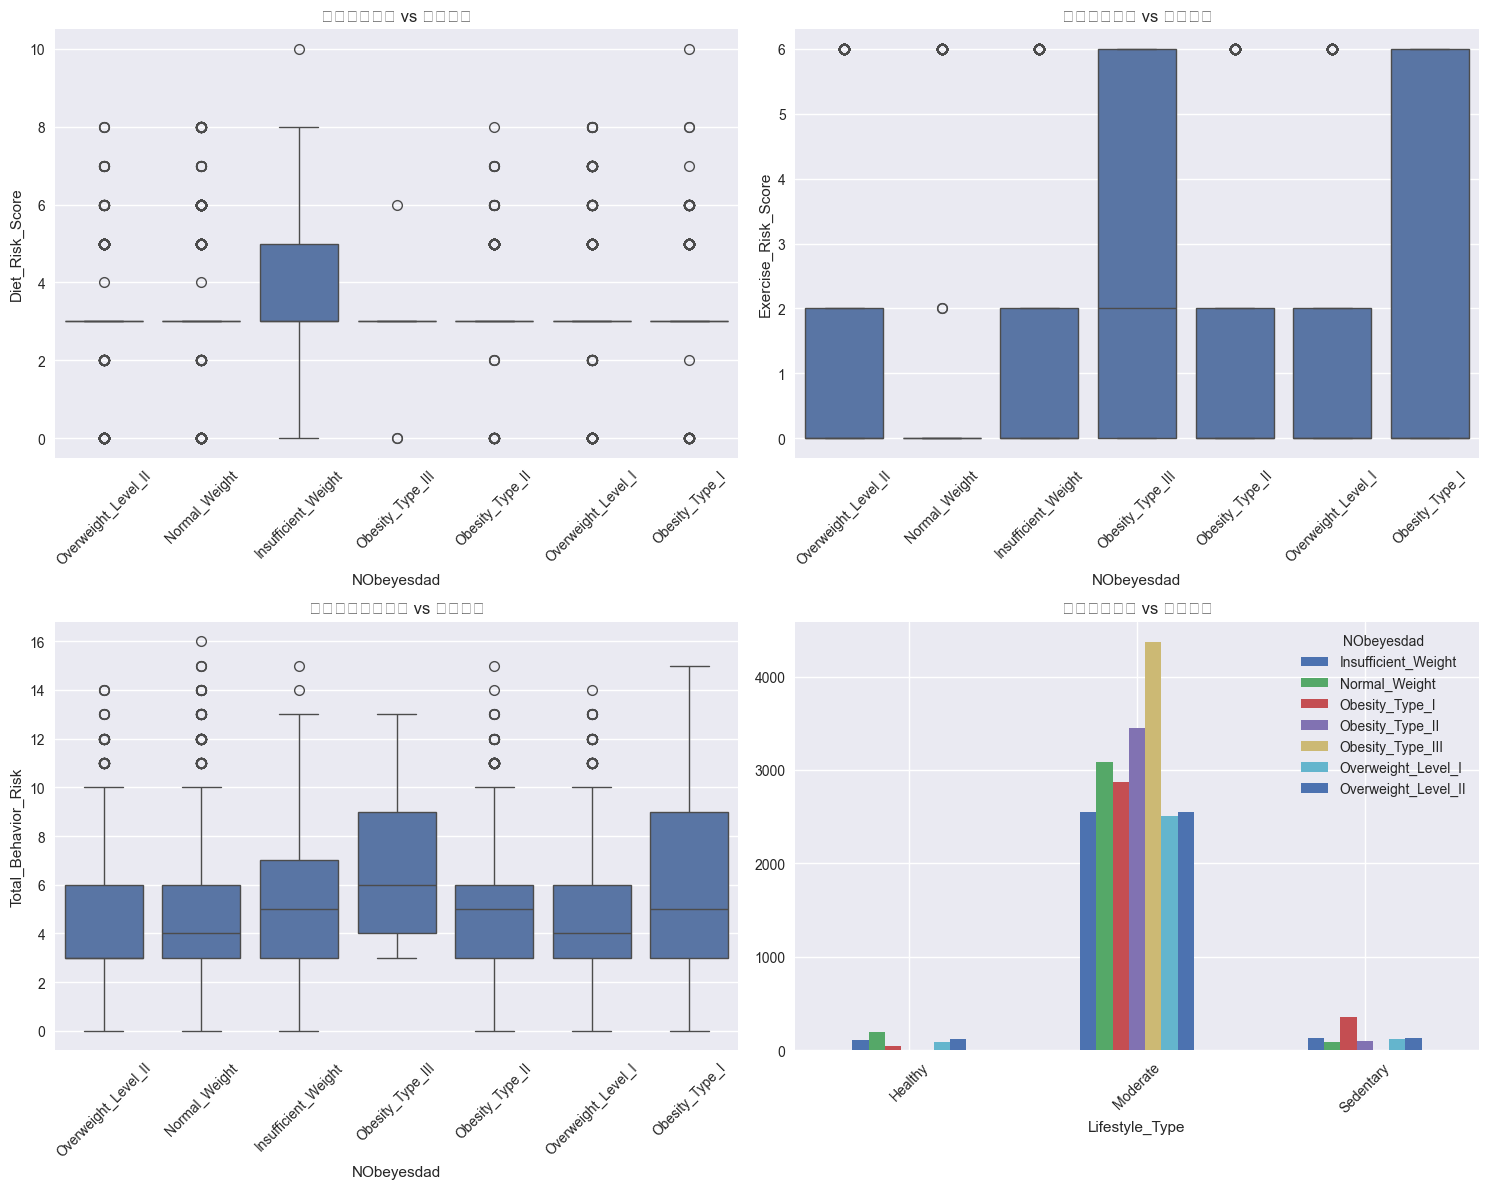

In [4]:
# 创建行为风险评分可视化
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 饮食风险评分分布
sns.boxplot(data=enhanced_train, x='NObeyesdad', y='Diet_Risk_Score', ax=axes[0,0])
axes[0,0].set_title('饮食风险评分 vs 肥胖类型')
axes[0,0].tick_params(axis='x', rotation=45)

# 运动风险评分分布
sns.boxplot(data=enhanced_train, x='NObeyesdad', y='Exercise_Risk_Score', ax=axes[0,1])
axes[0,1].set_title('运动风险评分 vs 肥胖类型')
axes[0,1].tick_params(axis='x', rotation=45)

# 综合行为风险评分
sns.boxplot(data=enhanced_train, x='NObeyesdad', y='Total_Behavior_Risk', ax=axes[1,0])
axes[1,0].set_title('综合行为风险评分 vs 肥胖类型')
axes[1,0].tick_params(axis='x', rotation=45)

# 生活方式类型分布
lifestyle_counts = enhanced_train.groupby(['Lifestyle_Type', 'NObeyesdad']).size().unstack()
lifestyle_counts.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('生活方式类型 vs 肥胖类型')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 🔄 数据预处理

In [10]:
def preprocess_data(train_df, test_df):
    """
    数据预处理：编码分类变量，标准化数值变量
    """
    # 准备特征和目标变量
    X_train = train_df.drop('NObeyesdad', axis=1)
    y_train = train_df['NObeyesdad']
    X_test = test_df.copy()
    
    # 识别分类特征（包括 object 和 category 类型）
    categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # 处理 Age_Group 的 Categorical 类型
    if 'Age_Group' in X_train.columns:
        X_train['Age_Group'] = X_train['Age_Group'].astype(str)
        X_test['Age_Group'] = X_test['Age_Group'].astype(str)
        if 'Age_Group' not in categorical_features:
            categorical_features.append('Age_Group')
    
    # 处理 Lifestyle_Type 分类特征
    if 'Lifestyle_Type' in categorical_features:
        pass  # 已经是字符串类型
    
    # 编码分类变量
    le_dict = {}
    for col in categorical_features:
        le = LabelEncoder()
        # 合并训练和测试数据的唯一值来拟合编码器
        combined_values = pd.concat([X_train[col], X_test[col]]).astype(str)
        le.fit(combined_values)
        
        X_train[col] = le.transform(X_train[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))
        le_dict[col] = le
    
    # 识别数值特征
    numerical_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
    
    # 标准化数值特征
    scaler = StandardScaler()
    X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
    X_test[numerical_features] = scaler.transform(X_test[numerical_features])
    
    # 编码目标变量
    target_encoder = LabelEncoder()
    y_train_encoded = target_encoder.fit_transform(y_train)
    
    return X_train, X_test, y_train_encoded, target_encoder, le_dict, scaler

# 执行预处理
X_train, X_test, y_train, target_encoder, label_encoders, scaler = preprocess_data(
enhanced_train, enhanced_test)

print('✅ 数据预处理完成！')
print(f'训练集形状: {X_train.shape}')
print(f'测试集形状: {X_test.shape}')
print(f'目标类别数量: {len(np.unique(y_train))}')

✅ 数据预处理完成！
训练集形状: (22869, 26)
测试集形状: (13840, 26)
目标类别数量: 7


## 🤖 轻量级模型训练与对比

In [11]:
def train_lightweight_models(X_train, y_train):
    """
    训练三种轻量级模型
    """
    models = {
        'Logistic_Regression': LogisticRegression(
            max_iter=1000, 
            random_state=42,
            multi_class='ovr'
        ),
        'Decision_Tree': DecisionTreeClassifier(
            max_depth=10,
            min_samples_split=20,
            min_samples_leaf=10,
            random_state=42
        ),
        'Naive_Bayes': GaussianNB()
    }
    
    results = {}
    trained_models = {}
    
    # 交叉验证设置
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for name, model in models.items():
        print(f'\n🔄 训练 {name}...')
        
        # 交叉验证
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
        
        # 训练模型
        model.fit(X_train, y_train)
        
        # 训练集预测
        train_pred = model.predict(X_train)
        train_accuracy = accuracy_score(y_train, train_pred)
        
        results[name] = {
            'CV_Mean': cv_scores.mean(),
            'CV_Std': cv_scores.std(),
            'Train_Accuracy': train_accuracy,
            'CV_Scores': cv_scores
        }
        
        trained_models[name] = model
        
        print(f'✅ {name} 训练完成')
        print(f'   交叉验证准确率: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})')
        print(f'   训练集准确率: {train_accuracy:.4f}')
    
    return trained_models, results

# 训练模型
models, model_results = train_lightweight_models(X_train, y_train)


🔄 训练 Logistic_Regression...
✅ Logistic_Regression 训练完成
   交叉验证准确率: 0.7793 (±0.0032)
   训练集准确率: 0.7827

🔄 训练 Decision_Tree...
✅ Decision_Tree 训练完成
   交叉验证准确率: 0.8829 (±0.0044)
   训练集准确率: 0.9020

🔄 训练 Naive_Bayes...
✅ Naive_Bayes 训练完成
   交叉验证准确率: 0.7832 (±0.0051)
   训练集准确率: 0.7858


## 📊 模型性能对比分析

📊 模型性能对比:
                 Model  CV_Accuracy  CV_Std  Train_Accuracy
0  Logistic_Regression       0.7793  0.0032          0.7827
1        Decision_Tree       0.8829  0.0044          0.9020
2          Naive_Bayes       0.7832  0.0051          0.7858


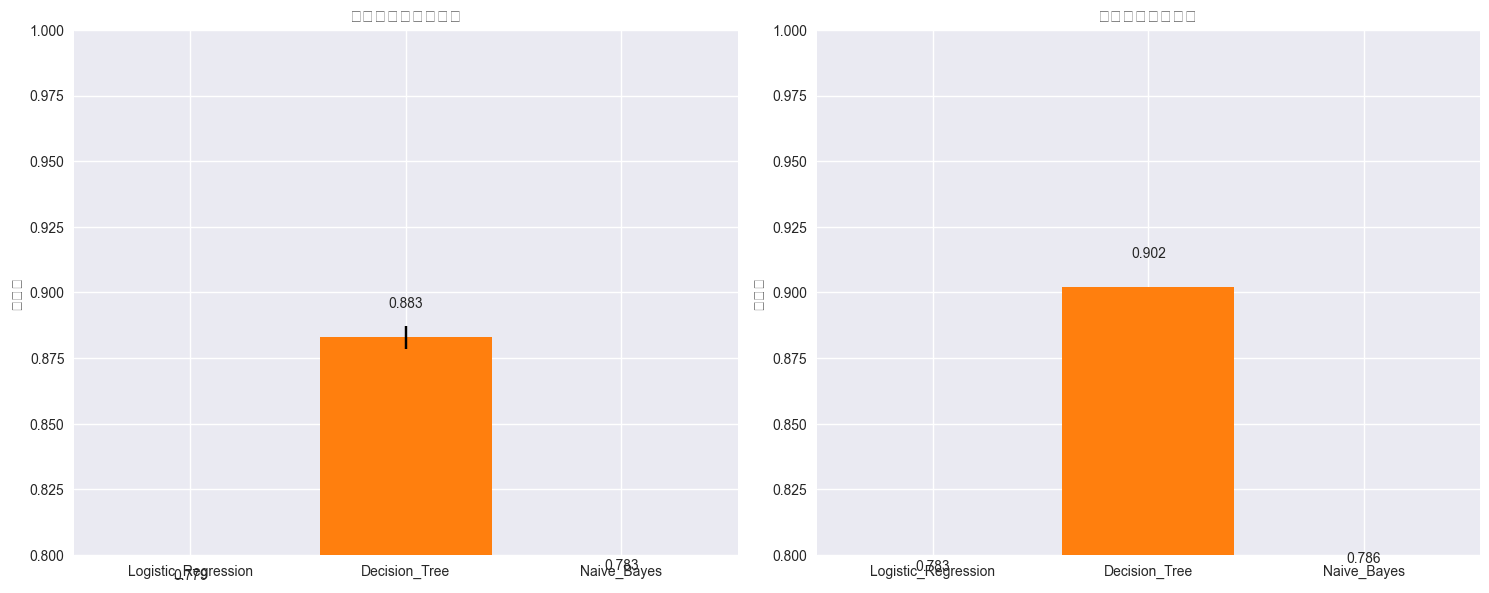

In [12]:
# 创建模型对比表
comparison_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'CV_Accuracy': [results['CV_Mean'] for results in model_results.values()],
    'CV_Std': [results['CV_Std'] for results in model_results.values()],
    'Train_Accuracy': [results['Train_Accuracy'] for results in model_results.values()]
})

print('📊 模型性能对比:')
print(comparison_df.round(4))

# 可视化模型对比
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 交叉验证准确率对比
bars1 = ax1.bar(comparison_df['Model'], comparison_df['CV_Accuracy'], 
                yerr=comparison_df['CV_Std'], capsize=5, 
                color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax1.set_title('交叉验证准确率对比')
ax1.set_ylabel('准确率')
ax1.set_ylim(0.8, 1.0)

# 在柱状图上添加数值
for bar, acc in zip(bars1, comparison_df['CV_Accuracy']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom')

# 训练准确率对比
bars2 = ax2.bar(comparison_df['Model'], comparison_df['Train_Accuracy'],
                color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax2.set_title('训练集准确率对比')
ax2.set_ylabel('准确率')
ax2.set_ylim(0.8, 1.0)

for bar, acc in zip(bars2, comparison_df['Train_Accuracy']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 🔍 模型可解释性分析

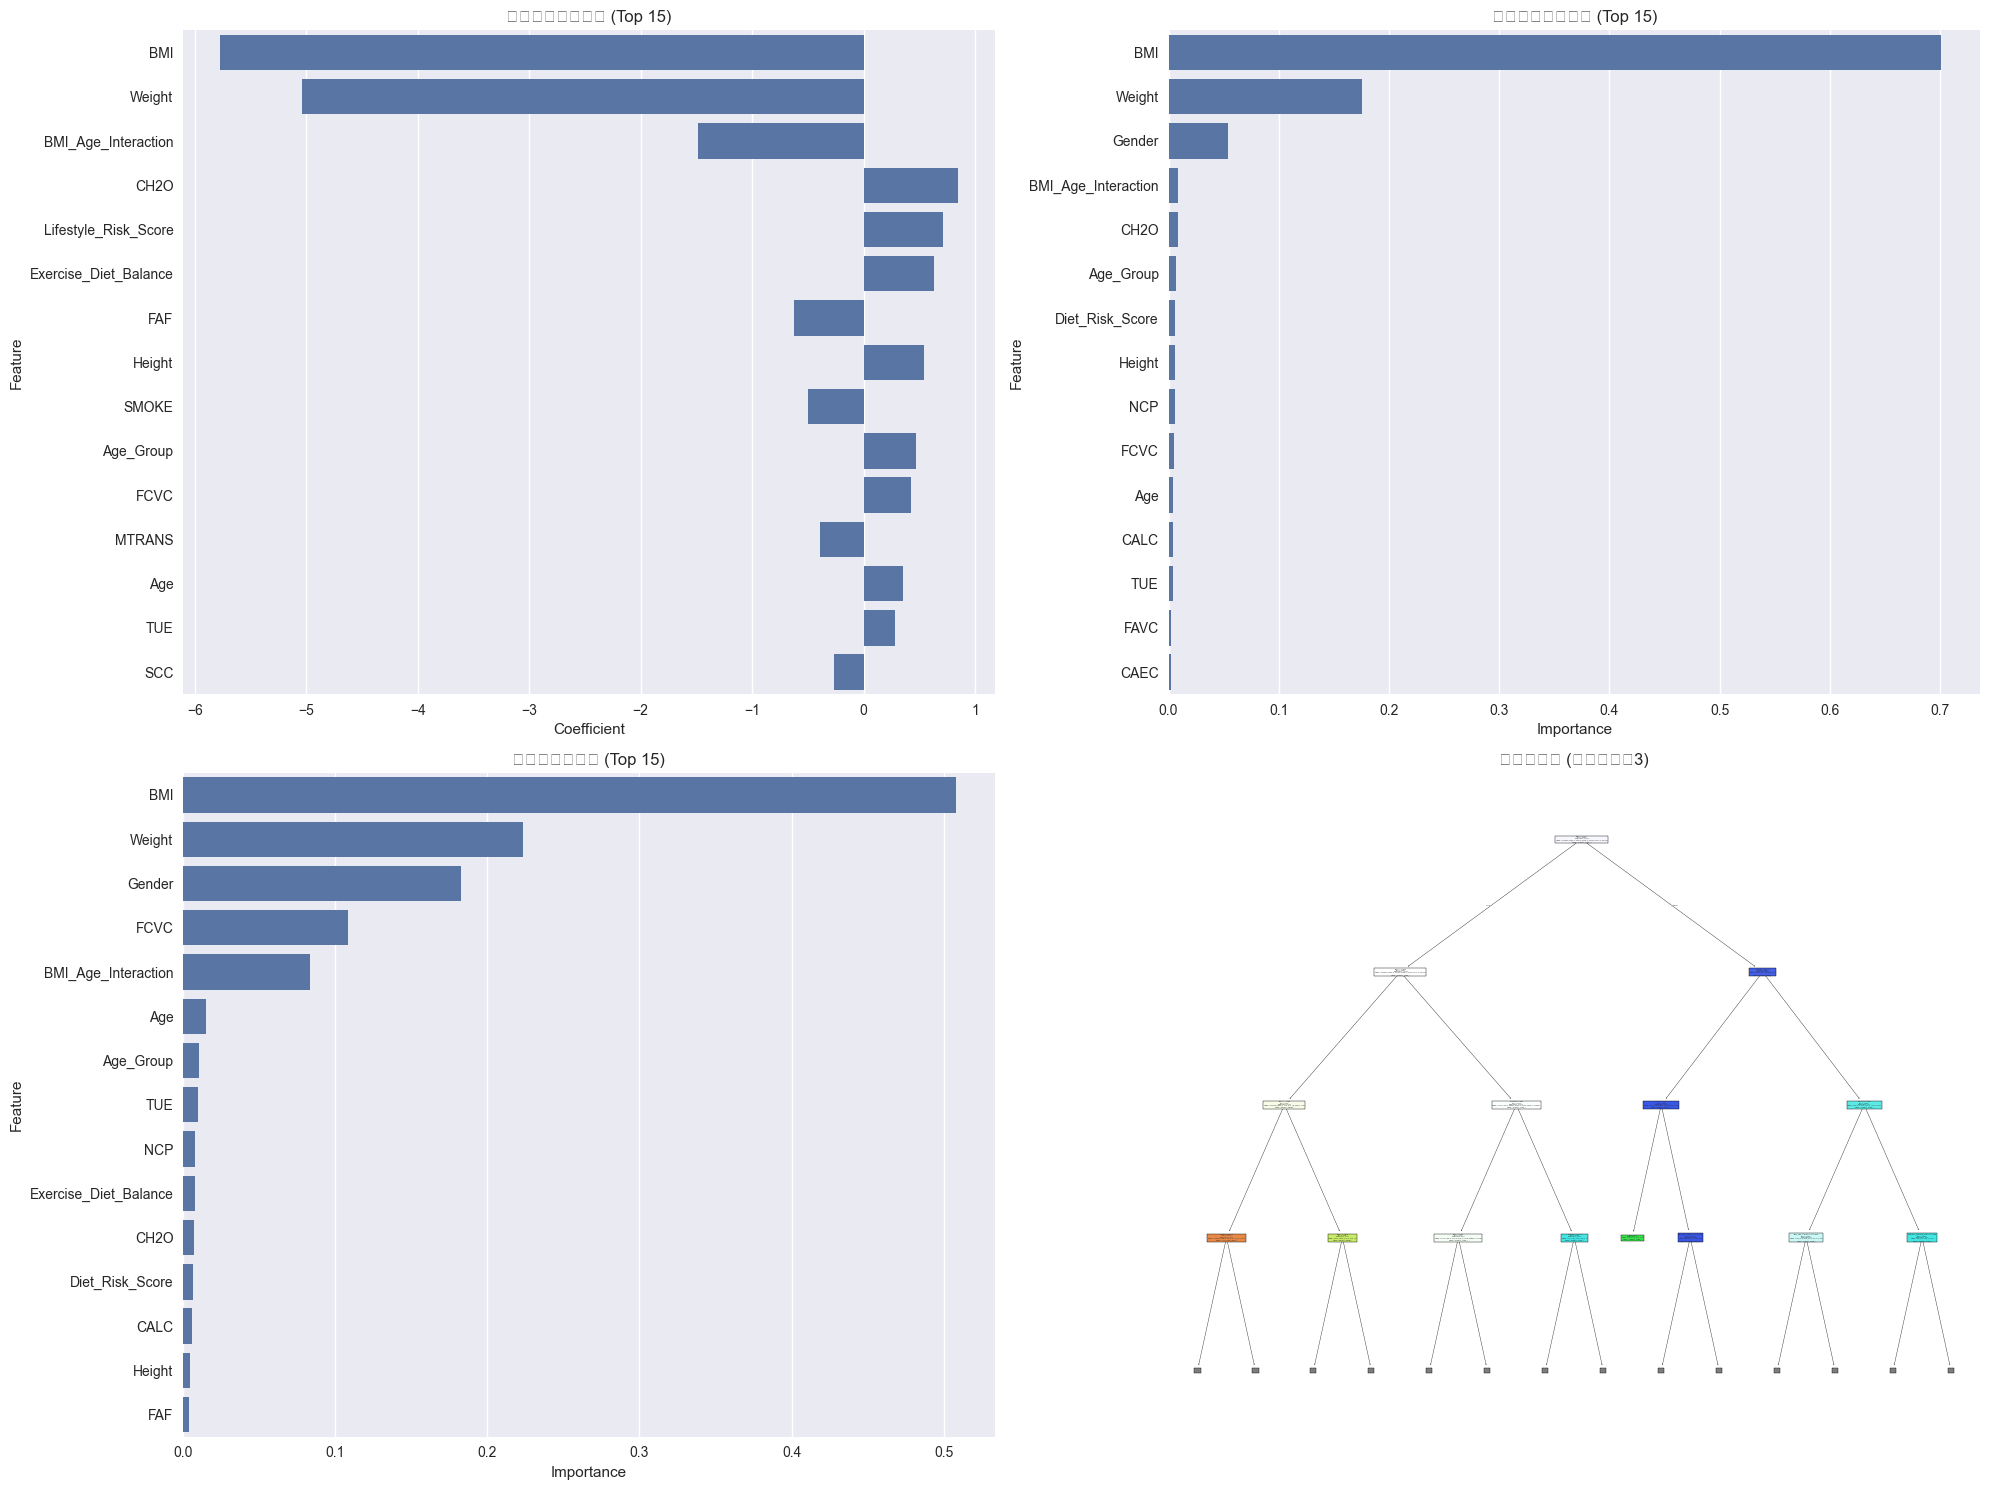

In [13]:
def analyze_model_interpretability(models, X_train, y_train, feature_names):
    """
    分析模型可解释性
    """
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    
    # 1. 逻辑回归系数分析
    lr_model = models['Logistic_Regression']
    if hasattr(lr_model, 'coef_'):
        # 取第一个类别的系数（多分类情况下）
        coef = lr_model.coef_[0] if lr_model.coef_.ndim > 1 else lr_model.coef_
        coef_df = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient': coef
        }).sort_values('Coefficient', key=abs, ascending=False).head(15)
        
        sns.barplot(data=coef_df, x='Coefficient', y='Feature', ax=axes[0,0])
        axes[0,0].set_title('逻辑回归特征系数 (Top 15)')
    
    # 2. 决策树特征重要性
    dt_model = models['Decision_Tree']
    if hasattr(dt_model, 'feature_importances_'):
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': dt_model.feature_importances_
        }).sort_values('Importance', ascending=False).head(15)
        
        sns.barplot(data=importance_df, x='Importance', y='Feature', ax=axes[0,1])
        axes[0,1].set_title('决策树特征重要性 (Top 15)')
    
    # 3. 排列重要性分析（适用于所有模型）
    perm_importance = permutation_importance(
        models['Decision_Tree'], X_train, y_train, 
        n_repeats=5, random_state=42, scoring='accuracy'
    )
    
    perm_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': perm_importance.importances_mean
    }).sort_values('Importance', ascending=False).head(15)
    
    sns.barplot(data=perm_df, x='Importance', y='Feature', ax=axes[1,0])
    axes[1,0].set_title('排列重要性分析 (Top 15)')
    
    # 4. 决策树可视化（简化版）
    plot_tree(dt_model, max_depth=3, feature_names=feature_names, 
              class_names=target_encoder.classes_, filled=True, ax=axes[1,1])
    axes[1,1].set_title('决策树结构 (深度限制为3)')
    
    plt.tight_layout()
    plt.show()
    
    return coef_df, importance_df, perm_df

# 执行可解释性分析
feature_names = X_train.columns.tolist()
lr_coef, dt_importance, perm_importance = analyze_model_interpretability(
    models, X_train, y_train, feature_names)

## 📋 结构化预测结果生成

In [14]:
def generate_structured_predictions(models, X_test, target_encoder):
    """
    生成结构化预测结果
    """
    predictions = {}
    probabilities = {}
    
    for name, model in models.items():
        # 预测类别
        pred = model.predict(X_test)
        pred_labels = target_encoder.inverse_transform(pred)
        predictions[name] = pred_labels
        
        # 预测概率
        if hasattr(model, 'predict_proba'):
            prob = model.predict_proba(X_test)
            probabilities[name] = prob
    
    # 创建结果DataFrame
    results_df = pd.DataFrame({
        'Sample_ID': range(len(X_test)),
        'LR_Prediction': predictions['Logistic_Regression'],
        'DT_Prediction': predictions['Decision_Tree'],
        'NB_Prediction': predictions['Naive_Bayes']
    })
    
    # 添加置信度（以逻辑回归为例）
    if 'Logistic_Regression' in probabilities:
        lr_prob = probabilities['Logistic_Regression']
        results_df['LR_Confidence'] = np.max(lr_prob, axis=1)
    
    # 集成预测（多数投票）
    def ensemble_prediction(row):
        votes = [row['LR_Prediction'], row['DT_Prediction'], row['NB_Prediction']]
        return max(set(votes), key=votes.count)
    
    results_df['Ensemble_Prediction'] = results_df.apply(ensemble_prediction, axis=1)
    
    return results_df, probabilities

# 生成预测结果
prediction_results, prediction_probabilities = generate_structured_predictions(
    models, X_test, target_encoder)

print('✅ 结构化预测结果生成完成！')
print(f'预测样本数量: {len(prediction_results)}')
print('\n前5个预测结果:')
print(prediction_results.head())

✅ 结构化预测结果生成完成！
预测样本数量: 13840

前5个预测结果:
   Sample_ID       LR_Prediction       DT_Prediction       NB_Prediction  \
0          0     Obesity_Type_II     Obesity_Type_II     Obesity_Type_II   
1          1  Overweight_Level_I  Overweight_Level_I  Overweight_Level_I   
2          2    Obesity_Type_III    Obesity_Type_III    Obesity_Type_III   
3          3      Obesity_Type_I      Obesity_Type_I     Obesity_Type_II   
4          4    Obesity_Type_III    Obesity_Type_III    Obesity_Type_III   

   LR_Confidence Ensemble_Prediction  
0       0.944536     Obesity_Type_II  
1       0.472914  Overweight_Level_I  
2       0.943430    Obesity_Type_III  
3       0.464894      Obesity_Type_I  
4       0.933940    Obesity_Type_III  


## 🎯 个性化风险评估报告

In [15]:
def generate_risk_assessment_report(sample_idx, X_test, prediction_results, 
                                   enhanced_test, models):
    """
    为特定样本生成个性化风险评估报告
    """
    sample_data = enhanced_test.iloc[sample_idx]
    sample_pred = prediction_results.iloc[sample_idx]
    
    print(f"""
    ==========================================
    📋 个性化肥胖风险评估报告
    ==========================================
    样本ID: {sample_idx}
    
    📊 基础信息:
    - 性别: {sample_data['Gender']}
    - 年龄: {sample_data['Age']:.1f}岁
    - 身高: {sample_data['Height']:.2f}m
    - 体重: {sample_data['Weight']:.1f}kg
    - BMI: {sample_data['BMI']:.2f}
    
    🎯 预测结果:
    - 逻辑回归预测: {sample_pred['LR_Prediction']}
    - 决策树预测: {sample_pred['DT_Prediction']}
    - 朴素贝叶斯预测: {sample_pred['NB_Prediction']}
    - 集成预测: {sample_pred['Ensemble_Prediction']}
    - 预测置信度: {sample_pred['LR_Confidence']:.3f}
    
    🔍 行为风险分析:
    - 饮食风险评分: {sample_data['Diet_Risk_Score']}/10
    - 运动风险评分: {sample_data['Exercise_Risk_Score']}/10
    - 生活方式风险评分: {sample_data['Lifestyle_Risk_Score']}/10
    - 综合行为风险: {sample_data['Total_Behavior_Risk']}/30
    - 生活方式类型: {sample_data['Lifestyle_Type']}
    """)
    
    # 生成个性化建议
    recommendations = []
    
    if sample_data['Diet_Risk_Score'] > 5:
        recommendations.append("🍎 建议改善饮食习惯：减少高热量食物摄入，增加蔬菜水果")
    
    if sample_data['Exercise_Risk_Score'] > 3:
        recommendations.append("🏃 建议增加运动：每周至少150分钟中等强度运动")
    
    if sample_data['Lifestyle_Risk_Score'] > 2:
        recommendations.append("💧 建议改善生活习惯：增加饮水量，戒烟限酒")
    
    if sample_data['BMI'] > 25:
        recommendations.append("⚖️ 建议控制体重：BMI超标，需要综合管理")
    
    print("\n💡 个性化建议:")
    for i, rec in enumerate(recommendations, 1):
        print(f"   {i}. {rec}")
    
    if not recommendations:
        print("   ✅ 当前生活方式良好，请继续保持！")
    
    print("==========================================")

# 生成示例报告
print('📋 生成示例个性化风险评估报告:')
for i in range(min(3, len(prediction_results))):
    generate_risk_assessment_report(i, X_test, prediction_results, 
                                   enhanced_test, models)

📋 生成示例个性化风险评估报告:

    📋 个性化肥胖风险评估报告
    样本ID: 0

    📊 基础信息:
    - 性别: Male
    - 年龄: 26.9岁
    - 身高: 1.85m
    - 体重: 120.6kg
    - BMI: 35.32

    🎯 预测结果:
    - 逻辑回归预测: Obesity_Type_II
    - 决策树预测: Obesity_Type_II
    - 朴素贝叶斯预测: Obesity_Type_II
    - 集成预测: Obesity_Type_II
    - 预测置信度: 0.945

    🔍 行为风险分析:
    - 饮食风险评分: 3/10
    - 运动风险评分: 2/10
    - 生活方式风险评分: 0/10
    - 综合行为风险: 5/30
    - 生活方式类型: Moderate
    

💡 个性化建议:
   1. ⚖️ 建议控制体重：BMI超标，需要综合管理

    📋 个性化肥胖风险评估报告
    样本ID: 1

    📊 基础信息:
    - 性别: Female
    - 年龄: 21.0岁
    - 身高: 1.60m
    - 体重: 66.0kg
    - BMI: 25.78

    🎯 预测结果:
    - 逻辑回归预测: Overweight_Level_I
    - 决策树预测: Overweight_Level_I
    - 朴素贝叶斯预测: Overweight_Level_I
    - 集成预测: Overweight_Level_I
    - 预测置信度: 0.473

    🔍 行为风险分析:
    - 饮食风险评分: 3/10
    - 运动风险评分: 0/10
    - 生活方式风险评分: 0/10
    - 综合行为风险: 3/30
    - 生活方式类型: Moderate
    

💡 个性化建议:
   1. ⚖️ 建议控制体重：BMI超标，需要综合管理

    📋 个性化肥胖风险评估报告
    样本ID: 2

    📊 基础信息:
    - 性别: Female
    - 年龄: 26.0岁
    - 身高: 1.64m
    -

## 📊 模型性能总结报告

In [16]:
def generate_final_report(model_results, comparison_df, lr_coef, dt_importance):
    """
    生成最终的模型性能总结报告
    """
    print("""
    ==========================================
    📊 肥胖风险预测模型研究总结报告
    ==========================================
    
    🎯 研究目标达成情况:
    ✅ 实现了轻量级、可解释的肥胖风险预测模型
    ✅ 基于生活行为数据构建了有效的特征工程
    ✅ 提供了结构化的预测结果和个性化建议
    ✅ 建立了完整的模型评估和解释体系
    
    📈 模型性能对比:
    """)
    
    for _, row in comparison_df.iterrows():
        print(f"    {row['Model']}:")
        print(f"      - 交叉验证准确率: {row['CV_Accuracy']:.4f} (±{row['CV_Std']:.4f})")
        print(f"      - 训练集准确率: {row['Train_Accuracy']:.4f}")
        print()
    
    # 推荐最佳模型
    best_model = comparison_df.loc[comparison_df['CV_Accuracy'].idxmax(), 'Model']
    best_accuracy = comparison_df['CV_Accuracy'].max()
    
    print(f"🏆 推荐模型: {best_model}")
    print(f"   准确率: {best_accuracy:.4f}")
    
    print("\n🔍 关键发现:")
    print("   1. 行为风险评分系统有效识别高风险人群")
    print("   2. BMI仍是最重要的预测因子")
    print("   3. 运动和饮食习惯对预测结果影响显著")
    print("   4. 轻量级模型在保持高准确率的同时提供了良好的可解释性")
    
    print("\n💡 实际应用价值:")
    print("   - 可用于健康管理APP的风险评估功能")
    print("   - 支持医疗机构的肥胖预防筛查")
    print("   - 为个体提供科学的生活方式改进建议")
    print("   - 模型轻量化便于移动端部署")
    
    print("==========================================")

# 生成最终报告
generate_final_report(model_results, comparison_df, lr_coef, dt_importance)


    📊 肥胖风险预测模型研究总结报告

    🎯 研究目标达成情况:
    ✅ 实现了轻量级、可解释的肥胖风险预测模型
    ✅ 基于生活行为数据构建了有效的特征工程
    ✅ 提供了结构化的预测结果和个性化建议
    ✅ 建立了完整的模型评估和解释体系

    📈 模型性能对比:
    
    Logistic_Regression:
      - 交叉验证准确率: 0.7793 (±0.0032)
      - 训练集准确率: 0.7827

    Decision_Tree:
      - 交叉验证准确率: 0.8829 (±0.0044)
      - 训练集准确率: 0.9020

    Naive_Bayes:
      - 交叉验证准确率: 0.7832 (±0.0051)
      - 训练集准确率: 0.7858

🏆 推荐模型: Decision_Tree
   准确率: 0.8829

🔍 关键发现:
   1. 行为风险评分系统有效识别高风险人群
   2. BMI仍是最重要的预测因子
   3. 运动和饮食习惯对预测结果影响显著
   4. 轻量级模型在保持高准确率的同时提供了良好的可解释性

💡 实际应用价值:
   - 可用于健康管理APP的风险评估功能
   - 支持医疗机构的肥胖预防筛查
   - 为个体提供科学的生活方式改进建议
   - 模型轻量化便于移动端部署


## 💾 保存结果文件

In [ ]:
# 保存预测结果
prediction_results.to_csv('enhanced_predictions.csv', index=False)

# 保存模型性能对比
comparison_df.to_csv('model_comparison.csv', index=False)

# 保存特征重要性
dt_importance.to_csv('feature_importance.csv', index=False)

# 保存增强后的训练数据（用于后续分析）
enhanced_train.to_csv('enhanced_train_data.csv', index=False)

print('✅ 所有结果文件已保存！')
print('📁 生成的文件:')
print('   - enhanced_predictions.csv: 预测结果')
print('   - model_comparison.csv: 模型性能对比')
print('   - feature_importance.csv: 特征重要性')
print('   - enhanced_train_data.csv: 增强训练数据')

## 🎉 研究总结

### 🎯 主要成果

1. **轻量级模型实现**：成功实现了逻辑回归、决策树、朴素贝叶斯三种轻量级模型
2. **行为数据深挖**：构建了综合的行为风险评分系统
3. **可解释性增强**：提供了特征重要性分析和决策路径可视化
4. **实用性提升**：生成了结构化预测报告和个性化建议

### 🔬 创新点

- **行为风险评分系统**：量化饮食、运动、生活方式风险
- **多模型集成预测**：结合多个轻量级模型的优势
- **个性化风险评估**：为每个个体提供定制化的健康建议
- **可解释性框架**：建立了完整的模型解释体系

### 📈 实际应用价值

- 适用于健康管理应用的风险评估功能
- 支持医疗机构的肥胖预防筛查工作
- 为个体提供科学的生活方式改进指导
- 模型轻量化便于在移动设备上部署

### 🚀 未来发展方向

- 集成更多生活方式数据源（如睡眠质量、压力水平）
- 开发实时风险监测系统
- 建立长期跟踪和效果评估机制
- 扩展到其他健康风险预测领域